# Chargement des libraires, atlas (parcellation), surfaces etc..

In [ ]:
import os
import glob
import pandas as pd 
import numpy as np
import math
#import plotnine as p9
import matplotlib.pyplot as plt
try :
    import seaborn as sns
except : 
    ! pip install seaborn
    import seaborn as sns
try :
    import nibabel as nib
except : 
    ! pip install nibabel
    import nibabel as nib

from skimage.util import montage 
from skimage.transform import rotate
try : 
    import openxyl
except : 
    ! pip install openpyxl

from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#%matplotlib notebook
import laBIBILaRORO as lbr

try :
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
except : 
    ! pip install brainstat
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation

try :
    from nilearn import surface, datasets, plotting
    import nilearn# Chargement des données propre à l'étude
except : 
    !pip install nilearn
    from nilearn import surface, datasets, plotting
    import nilearn    
    
from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from IPython.display import display,Image
import statsmodels.api as sm
from brainstat.stats.terms import FixedEffect
from brainstat.stats.terms import MixedEffect
from brainstat.stats.SLM import SLM
import scipy.stats as stats
from scipy.stats import ttest_ind
import laBIBILaRORO as lbr

La bibil à RORO loaded


In [3]:
pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
mask_fslr32k = fetch_mask("fslr32k")
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

In [4]:
file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/HCP-MMP1_UniqueRegionList.csv'
df_exthcp = pd.read_csv(file_path)
#print(df_exthcp.head())  # Affiche les premières lignes du DataFrame

file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/Glasser_2016_Table-1.xlsx'
df_gla = pd.read_excel(file_path)
#df_gla

#attention entre el numero de regionID et le numero dans numpy ndarray il y aun decalge de 20 l'un recommence à 181 l'autre à 200
#mapping_dict = dict(zip(df_exthcp['regionID'], df_exthcp['Cortex_ID']))
mapping_dict = dict(zip(df_exthcp.index.values+1, df_exthcp['Cortex_ID']))

mapping_dict[0] = 0
def map_values(value):
    return mapping_dict.get(value, 400)  # Remplacer 0 par une autre valeur par défaut si nécessaire

for key in mapping_dict.keys():
    # Vérifier si la clé est supérieure à 180
    if key > 180:
        # Ajouter 22 à la valeur correspondante
        mapping_dict[key] += 22

# Utiliser np.vectorize pour appliquer la fonction de correspondance
vectorized_map = np.vectorize(map_values)
glasser_fslr32k_exthcp = vectorized_map(glasser_fslr32k)
glasser_exthcp = vectorized_map(glasser)

#verif 
#set(mapping_dict.values())

## Affiche des infos principales

In [11]:
print(f"number of points in fslr32k = {glasser_fslr32k.shape[0]}, left and right = {inflated_left_fslr32k.GetPoints().shape[0]}")
print(f"number of points in fsaverage = {glasser.shape[0]}, left and right = {inflated_right.GetPoints().shape[0]}")
print(f"number of ROI values in glasser = {len(np.unique(glasser))}")
print(f"number of ROI values in HCP extended = {len(np.unique(glasser_fslr32k_exthcp))}")

number of points in fslr32k = 64984, left and right = 32492
number of points in fsaverage = 20484, left and right = 10242
number of ROI values in glasser = 361
number of ROI values in HCP extended = 45


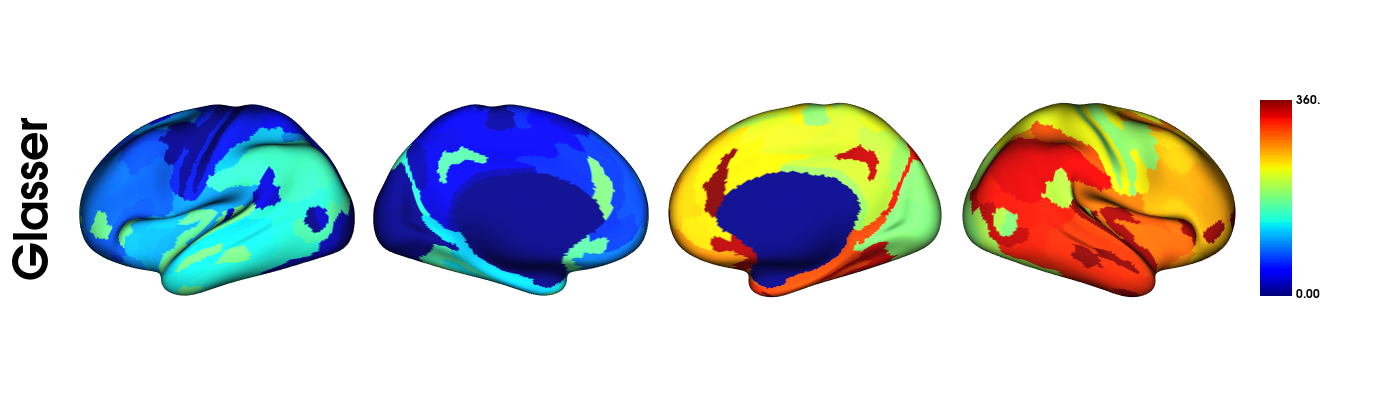

In [12]:
#np.where(np.isin(glasser_fslr32k, [1,4,5,6]),glasser_fslr32k, 0)glasser_fslr32k
#plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,np.where(np.isin(glasser_fslr32k, [180,360,96,276]),glasser_fslr32k, 0), color_bar=True,
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k, color_bar=True,                 
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

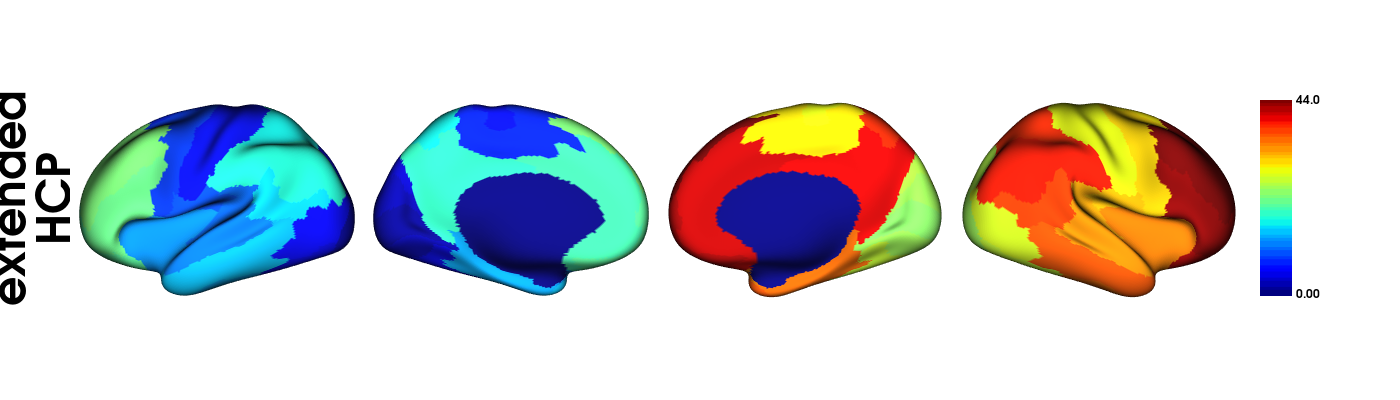

In [13]:
#np.where(np.isin(glasser_fslr32k, [1,2,3,4]),glasser_fslr32k, 0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k_exthcp, color_bar=True,
        label_text=["extended\nHCP"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

# Chargement des données propre à l'étude

In [14]:
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII")
SCRIPT_PATH=os.path.join(STUDY_PATH,'scripts')
LOG_PATH=os.path.join(SCRIPT_PATH,'log')
DATA_FILE=os.path.join(STUDY_PATH,"AdrianPiotto_M1",'DataAnxAP.xlsx')
CQ_FILE=os.path.join(STUDY_PATH,'FairparkII_MRIData_20210817.xlsx')

In [15]:
CQData = pd.read_excel(CQ_FILE,index_col=0,engine='openpyxl')
CLIData = pd.read_excel(DATA_FILE,index_col=0,engine='openpyxl')

In [16]:
# Filtrer les individus avec un score "MDS1 1.4" > 0
filtered_data = CLIData[CLIData['MDS 1.4'] > 0]
# Compter le nombre d'individus
count = filtered_data.shape[0]
print(f"Nombre d'individus avec un score de 'MDS1 1.4' > 0 : {count}")

Nombre d'individus avec un score de 'MDS1 1.4' > 0 : 114


In [17]:
CLIData['ANX'] = CLIData['MDS 1.4'].apply(lambda x: 1 if x > 0 else 0)
CLIData.index = CLIData.index.str.replace('^sub-', '', regex=True).str.replace('_ses-W00$', '', regex=True)

In [18]:
df_W00=CQData.query("SUBJ.str.endswith('W00')")
df_W00.index=df_W00.index.str[:-8]

# Filtrer df_W00 pour obtenir les sujets avec QC_3DT1 > 1
filtered_df_W00 = df_W00[df_W00['QC_3DT1'] > 1]

# Faire une jointure entre CLIData et filtered_df_W00 sur l'index
merged_data = CLIData.merge(filtered_df_W00, left_index=True, right_index=True, how='inner')

In [19]:
concatenated_list=df_exthcp['cortex'].astype(str)+"_"+df_exthcp['LR']#+"_"+df_exthcp["Cortex_ID"].astype(str)
concatenated_list=["EXT"]+list(concatenated_list.unique())

In [142]:
#    df_res.to_csv(os.path.join(STUDY_PATH,f"CTatM6_sm{sm}.csv"))
merged_data['Sexe']=merged_data['Sexe'].replace({1:'M',0:'F'}) # a verifier que c'est bien ca
merged_data['GROUP_NAME']=merged_data['ANX'].replace({1:'ANX',0:'NO_ANX'})
merged_data= merged_data.rename_axis("SUBJ")

In [164]:
from scipy.ndimage import gaussian_filter

smoothing_range=range(0, 31, 10)

In [166]:
sigma

0.0

#Pour recuperer que les valeurs moyennes dans les 180 regions de glasser 
#file_W00_L=os.path.join(STUDY_PATH,'CorticalThickness',f'sub_{SUBJ}_ses_W00.L.pscalar.nii')
#nib.load(file_W00_L).get_fdata().shape

In [167]:
df_W00=CQData.query("SUBJ.str.endswith('W00')")
df_W00.index=df_W00.index.str[:-8]
df_W36=CQData.query("SUBJ.str.endswith('W36')")
df_W36.index=df_W36.index.str[:-8]
df_CQ_FULL = pd.concat([df_W00.add_suffix('_W00'), df_W36.add_suffix('_W36')], axis=1)


res= {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in smoothing_range}
res_exthcp={f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in smoothing_range}
valR2_W00_ANX = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in smoothing_range}
valR2_W00_NOANX = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in smoothing_range}

df_4test = df_CQ_FULL.query("(QC_3DT1_W00 > 1) & (QC_3DMULTI_W00 > 2) & (QC_3DT1_W36 > 1) & (QC_3DMULTI_W00 > 2) ")
fsaverage_nii = nilearn.datasets.fetch_surf_fsaverage()

df_4test = df_CQ_FULL.query("(QC_3DT1_W00 > 1) & (QC_3DMULTI_W00 > 2) & (QC_3DT1_W36 > 1) & (QC_3DMULTI_W00 > 2) ")
for smoothing_fwhm in smoothing_range:
    sigma = smoothing_fwhm / np.sqrt(8 * np.log(2))
    for SUBJ in merged_data.index:
        #print(SUBJ)
        #SUBJ=file.split('/')[6].split("_")[2]
        file_W00=os.path.join(STUDY_PATH,'T2Maps',f'rRAS_R2Map_sub-{SUBJ}_ses-W00_mni.nii.gz')
        # Calculer l'écart-type (sigma) à partir de la FWHM

        if os.path.exists(file_W00):
                
            img = nib.load(file_W00)
            texture_right = surface.vol_to_surf(img,fsaverage_nii.pial_right)
            texture_left  = surface.vol_to_surf(img,fsaverage_nii.pial_left)
            volOnSurface_W00 = np.concatenate([texture_left,texture_right], axis=0)
            # Appliquer le filtre gaussien
            smoothed_image = gaussian_filter(volOnSurface_W00, sigma=sigma)                
            if merged_data.loc[SUBJ,'ANX'] == 1 :
                valR2_W00_ANX[f"sm_{smoothing_fwhm}"].append(volOnSurface_W00*1000)             
            else :
                valR2_W00_NOANX[f"sm_{smoothing_fwhm}"].append(volOnSurface_W00*1000)  
        else :
            print("eliminated")
            merged_data=merged_data.drop(SUBJ)

        res[f"sm_{smoothing_fwhm}"].append([np.mean(volOnSurface_W00[glasser==x])for x in np.unique(glasser)])
        res_exthcp[f"sm_{smoothing_fwhm}"].append([np.mean(volOnSurface_W00[glasser_exthcp==x])for x in np.unique(glasser_exthcp)])

In [170]:
image_name

NameError: name 'image_name' is not defined

*******************************
smoothing_fwhm=0
*******************************
Quantile 1%: 0.0
Quantile 99%: 43.51227405411691


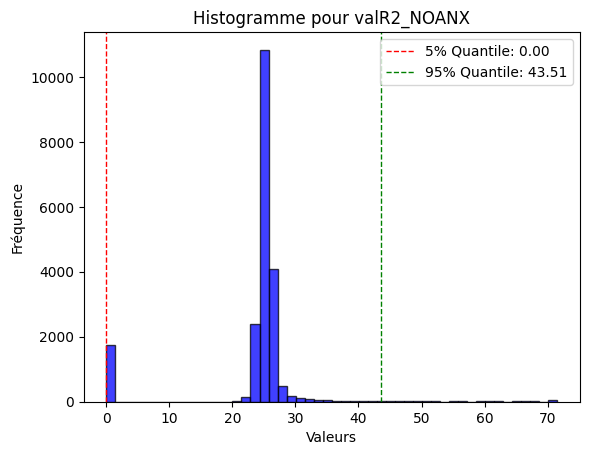

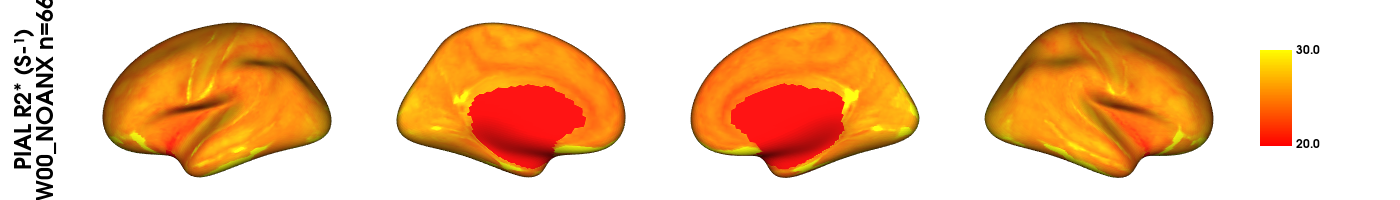

Quantile 1%: 0.0
Quantile 99%: 47.815129619541565


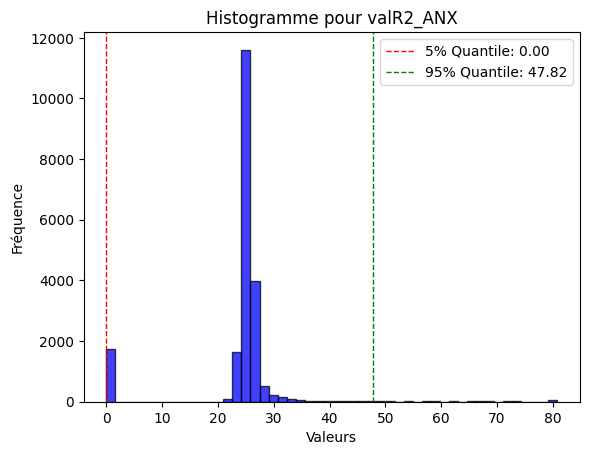

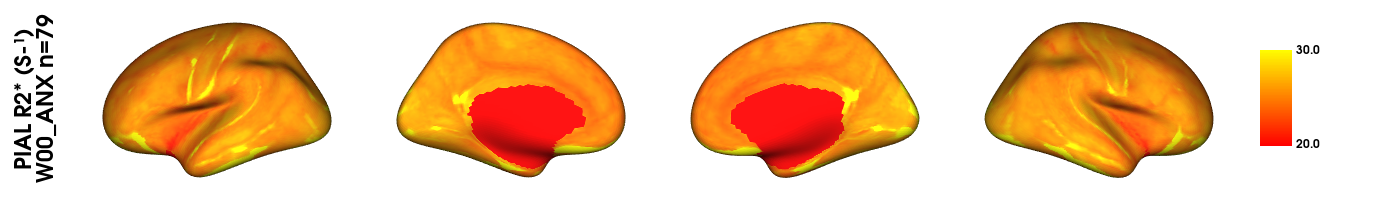

*******************************
smoothing_fwhm=10
*******************************
Quantile 1%: 0.0
Quantile 99%: 43.51227405411691


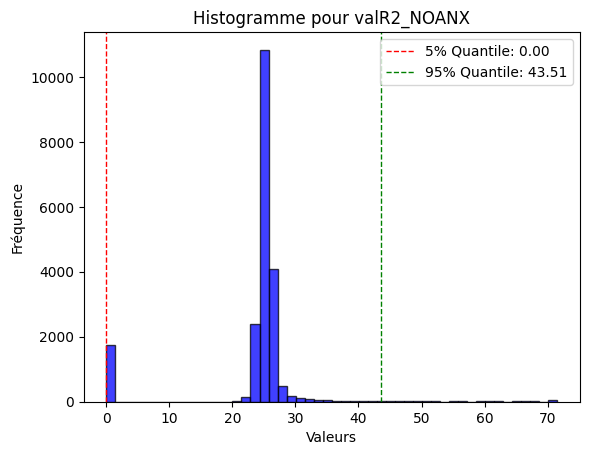

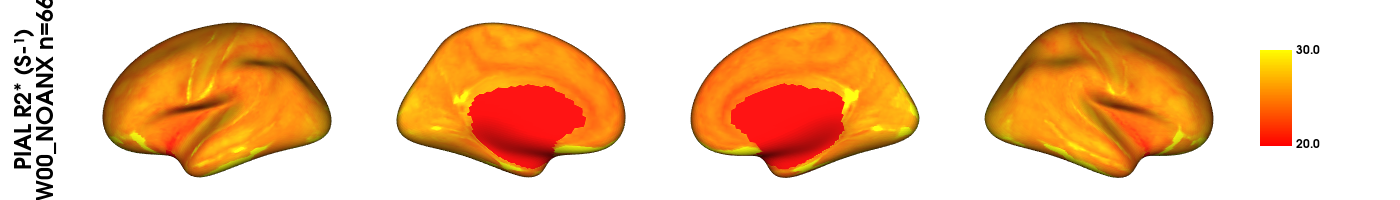

Quantile 1%: 0.0
Quantile 99%: 47.815129619541565


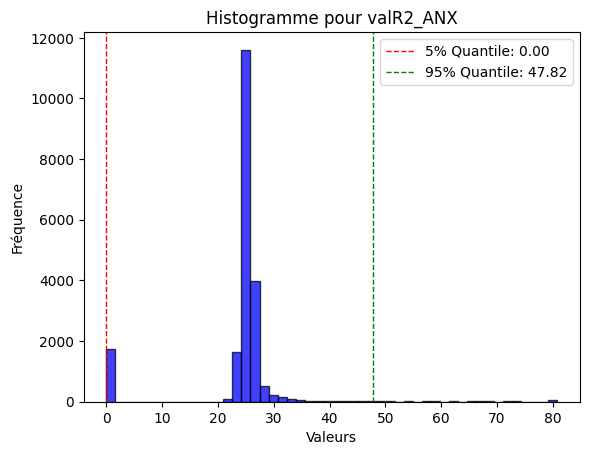

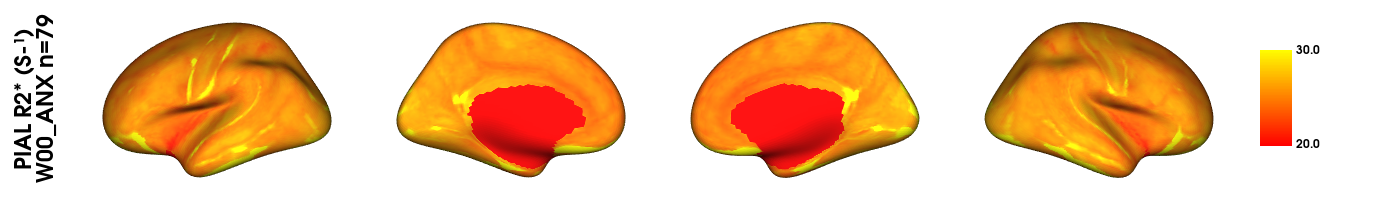

*******************************
smoothing_fwhm=20
*******************************
Quantile 1%: 0.0
Quantile 99%: 43.51227405411691


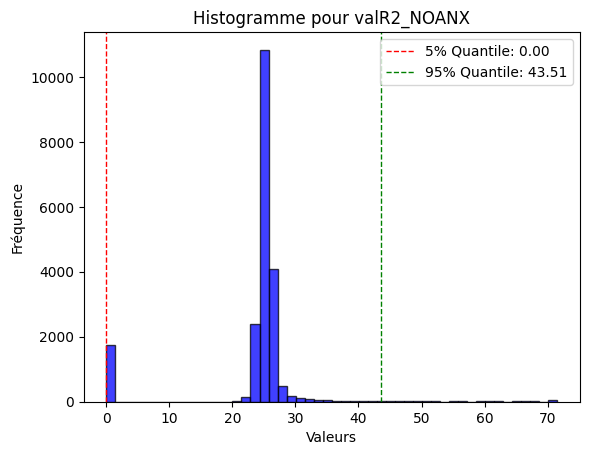

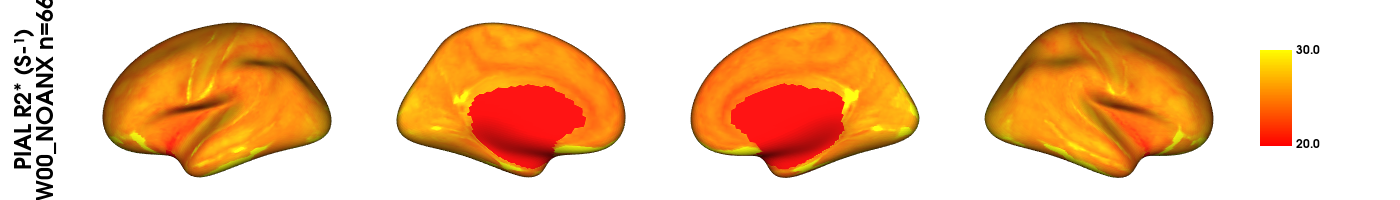

Quantile 1%: 0.0
Quantile 99%: 47.815129619541565


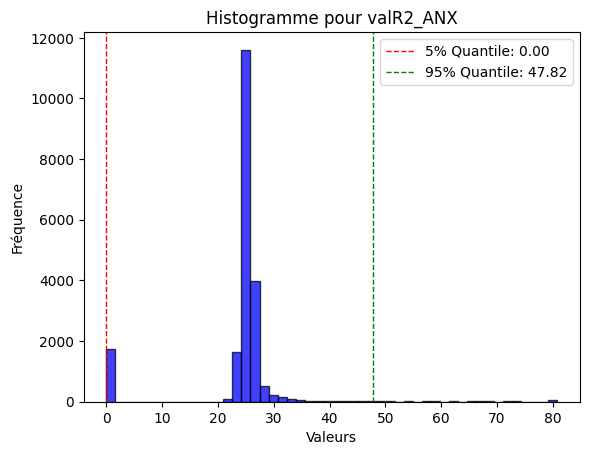

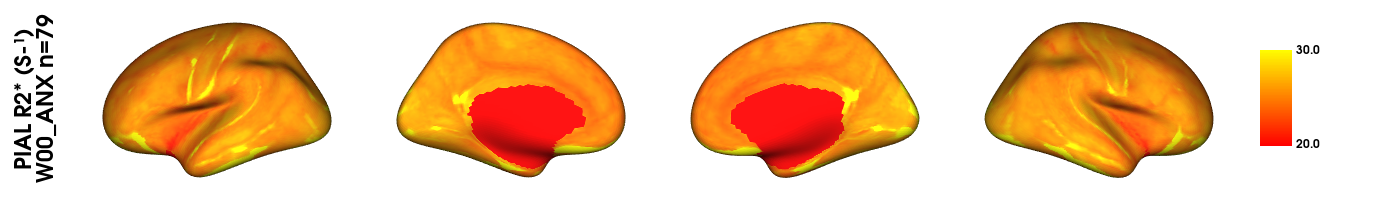

*******************************
smoothing_fwhm=30
*******************************
Quantile 1%: 0.0
Quantile 99%: 43.51227405411691


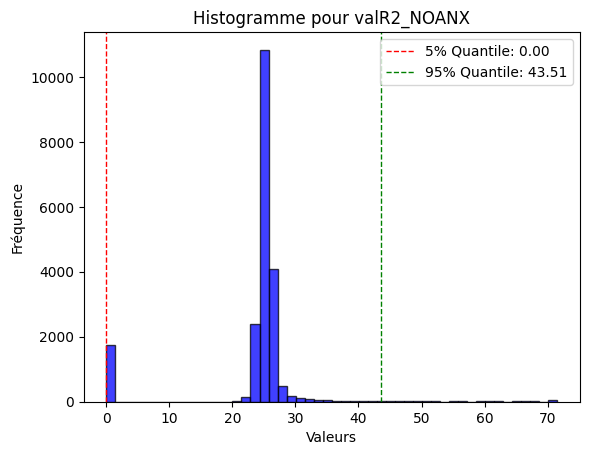

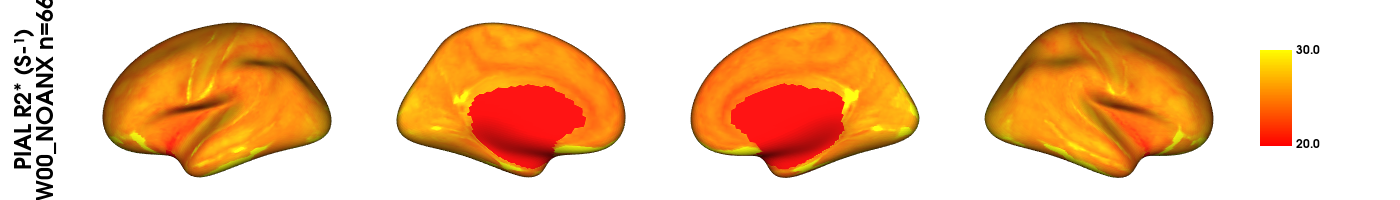

Quantile 1%: 0.0
Quantile 99%: 47.815129619541565


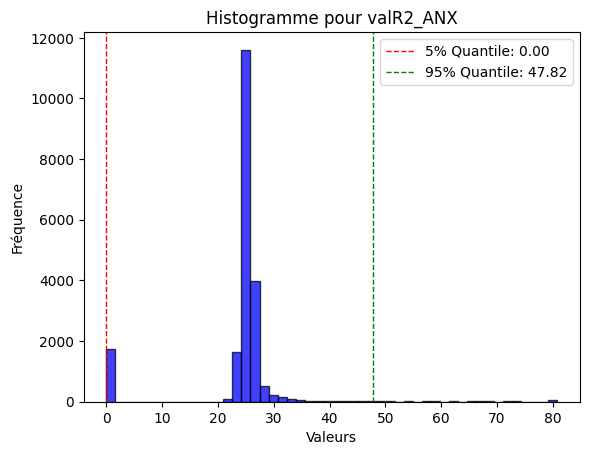

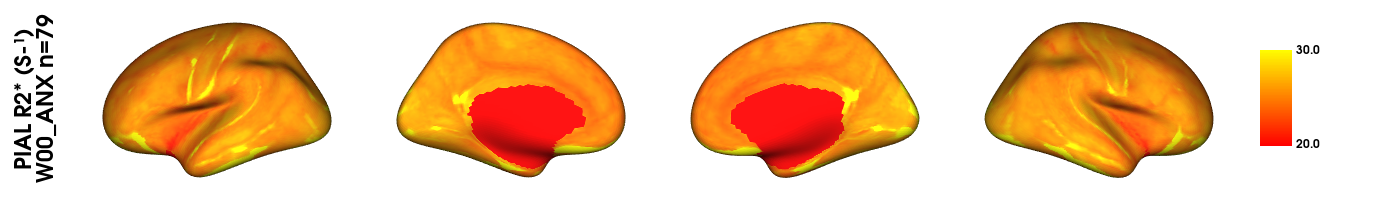

In [169]:
exposant_minus_1 = "⁻-¹"
# Définir une fonction pour traiter les données et afficher l'histogramme
def process_and_plot(listpat_values,image_name, label_text):
    # Appliquer le masque et multiplier par 1000
    tmp=np.array(listpat_values)
    tmp_c=np.clip(tmp,np.quantile(tmp,0.01),np.quantile(tmp,0.99))
    tmp_d=np.median(tmp_c,axis=0)

    # Appliquer le masque et le multiplier par 1000 est deja fait dans la cellule precendente
    data = (tmp_d ) * mask

    # Calculer les quantiles 5 et 95
    quantile_5 = np.percentile(data, 1)
    quantile_95 = np.percentile(data, 99)

    # Afficher les quantiles
    print(f"Quantile 1%: {quantile_5}")
    print(f"Quantile 99%: {quantile_95}")

    # Afficher l'histogramme
    plt.hist(data, bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.axvline(quantile_5, color='red', linestyle='dashed', linewidth=1, label=f'5% Quantile: {quantile_5:.2f}')
    plt.axvline(quantile_95, color='green', linestyle='dashed', linewidth=1, label=f'95% Quantile: {quantile_95:.2f}')
    plt.xlabel('Valeurs')
    plt.ylabel('Fréquence')
    plt.title(label_text)
    plt.legend()
    plt.savefig(image_name)
    plt.show()

    figure_title=os.path.join(STUDY_PATH,"screenshots",f"{image_name.replace("hist","map")}")
    plot_hemispheres(inflated_left,inflated_right,data, color_bar=True,
        label_text=[f"PIAL R2* (S{exposant_minus_1})\n{image_name[6:-9]}\n n={len(listpat_values)}"], cmap="autumn", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12},color_range=(20,30), 
        interactive=True,transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

for smoothing_fwhm in smoothing_range:
    # Appliquer la fonction aux deux variables
    print(f"*******************************")
    print(f"smoothing_fwhm={smoothing_fwhm}")
    print(f"*******************************")
    process_and_plot(valR2_W00_NOANX[f"sm_{smoothing_fwhm}"],'valR2_W00_NOANX_hist_sm{smoothing_fwhm}.png', 'Histogramme pour NOANX sm{smoothing_fwhm}')
    process_and_plot(valR2_W00_ANX[f"sm_{smoothing_fwhm}"],'valR2_W00_ANX_hist_sm{smoothing_fwhm}.png', 'Histogramme ANX sm{smoothing_fwhm}')

## Affichage des cartes d'épaisseurs corticales pour chaque groupe avec lissage à 10, 20 et 30 mm

## Affichage des cartes d'épaisseurs corticales après Z-Scores (individuel) pour chaque groupe avec lissage à 10, 20 et 30 mm

# Statistiques

## fsaverage5 : modèle linéaire généralisé (GLM)

In [144]:
term_sexe = FixedEffect(merged_data.Sexe)
model_sexe = term_sexe

#dans l'ordre initiale
term_group = FixedEffect(merged_data.GROUP_NAME)
model_group = term_group

#dans l'ordre ANX d'abord puis NO_ANX ensuite (pour faire comme dans la matrice qui l'on donne en entrée)
vecteur_ANX = merged_data['ANX'][merged_data['ANX'] == 1].values
vecteur_NO_ANX = merged_data['ANX'][merged_data['ANX'] == 0].values
df_GRP=["ANX" if x == 1 else "NO_ANX" for x in np.concatenate([vecteur_NO_ANX, vecteur_ANX])]

term_group = FixedEffect(df_GRP,"GRP")
model_group_sscov = term_group

#model_pasbdi= term_pas + term_bdi

#define dans l'ordre de merge dat 
#conrtrase 1(ANX),-1(NO_ANX)
contrast_group = (merged_data.GROUP_NAME == "ANX").astype(int) - (merged_data.GROUP_NAME == "NO_ANX").astype(int)
#ou contrast_group = (merged_data['ANX']== 1).astype(int) - (merged_data['ANX']== 0).astype(int)

#define dans l'ordre de merge dat 
#contraste 1(NO_ANX),-1(ANX)
#contrast_group=np.concatenate([vecteur_NO_ANX+1, vecteur_ANX-2])

In [150]:
reswocov_FIT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in smoothing_range}
reswcov_FIT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in smoothing_range}

for smoothing_fwhm in smoothing_range:
    val_CT = np.concatenate([valR2_W00_NOANX[f"sm_{smoothing_fwhm}"], valR2_W00_ANX[f"sm_{smoothing_fwhm}"]], axis=0)
    
    # Ajouter la colonne SUBJ_ID en utilisant les index
    merged_data_SUBJcol = merged_data.reset_index().rename(columns={'index': 'SUBJ'})
    
    # Définir les termes du modèle pour les groupes ANX et NO_ANX
    term_group = FixedEffect(merged_data_SUBJcol["GROUP_NAME"])
    term_age = FixedEffect(merged_data_SUBJcol["Age"])
    term_sex = FixedEffect(merged_data_SUBJcol["Sexe"])
    term_subject = MixedEffect(merged_data_SUBJcol["SUBJ"])
    
    # Créer le modèle sans covariables
    model_group = term_group + term_subject
    model_group_age_sex = term_group
    
    # Créer le modèle avec covariables
    #model_group_age_sex = term_group + term_age + term_sex + term_age * term_sex + term_subject
    for varc in ["Age","Sexe"]:
        model_group_age_sex = model_group_age_sex + FixedEffect(merged_data_SUBJcol[varc])
    
    # Ajuster le modèle sans covariables
    slm_group_sscov = SLM(
        model_group,
        contrast_group,
        surf=pial_combined,
        mask=mask,
        correction=["fdr", "rft"],
        two_tailed=True,
        cluster_threshold=0.05,
    )
    slm_group_sscov.fit(val_CT)
    reswocov_FIT[f"sm_{smoothing_fwhm}"] = slm_group_sscov
    
    # Ajuster le modèle avec covariables
    slm_group_wcov = SLM(
        model_group_age_sex,
        contrast_group,
        surf=pial_combined,
        mask=mask,
        correction=["fdr", "rft"],
        two_tailed=True,
        cluster_threshold=0.05,
    )
    slm_group_wcov.fit(val_CT)
    reswcov_FIT[f"sm_{smoothing_fwhm}"] = slm_group_wcov

### Contraste de groupe avec et sans prise en compte de covariables

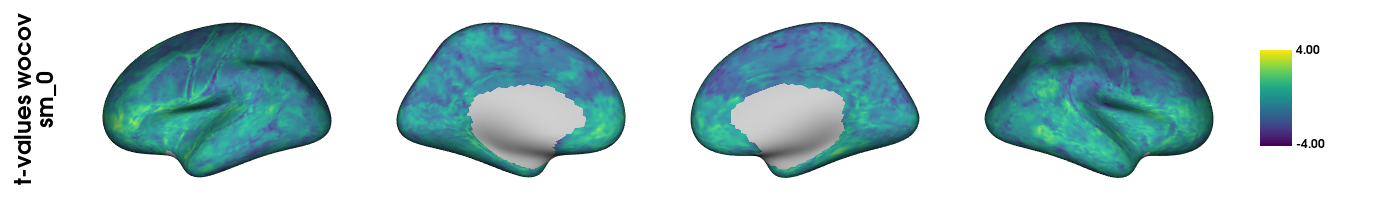

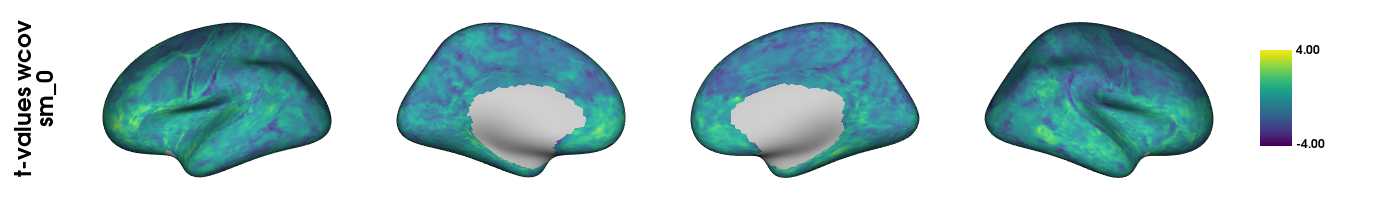

In [151]:
for values,name in zip([reswocov_FIT,reswcov_FIT],["wocov","wcov"]):
        for smoothing_fwhm in smoothing_range:
                figure_title=os.path.join(STUDY_PATH,"screenshots",f"t_stat_{name}_sm_{smoothing_fwhm}.png")
                plot_hemispheres(inflated_left,inflated_right,values[f'sm_{smoothing_fwhm}'].t, color_bar=True, color_range=(-4, 4),
                        label_text=[f"t-values {name}\nsm_{smoothing_fwhm}"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
                        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,
                        screenshot=True, offscreen=False,filename=figure_title)
                display(Image(filename=figure_title))

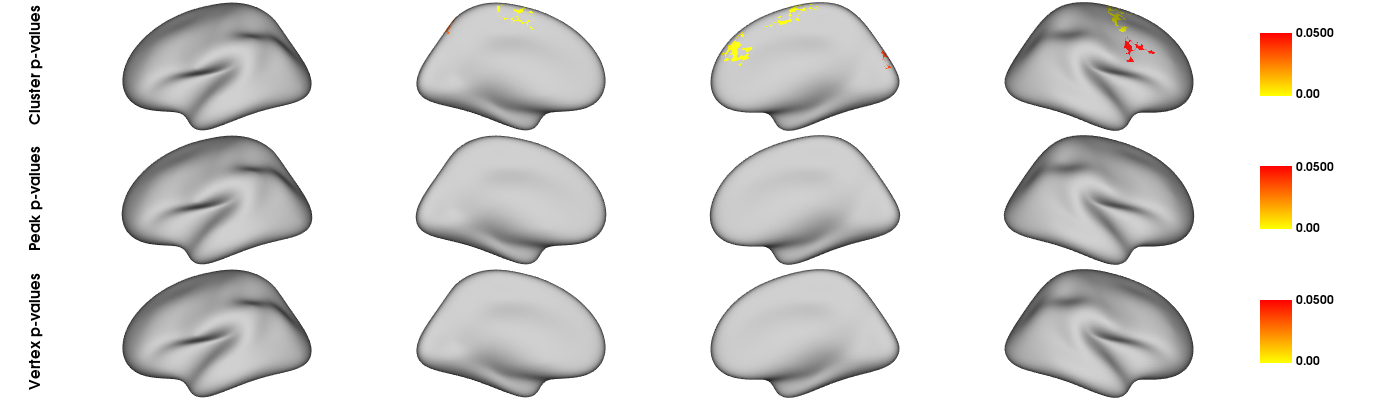

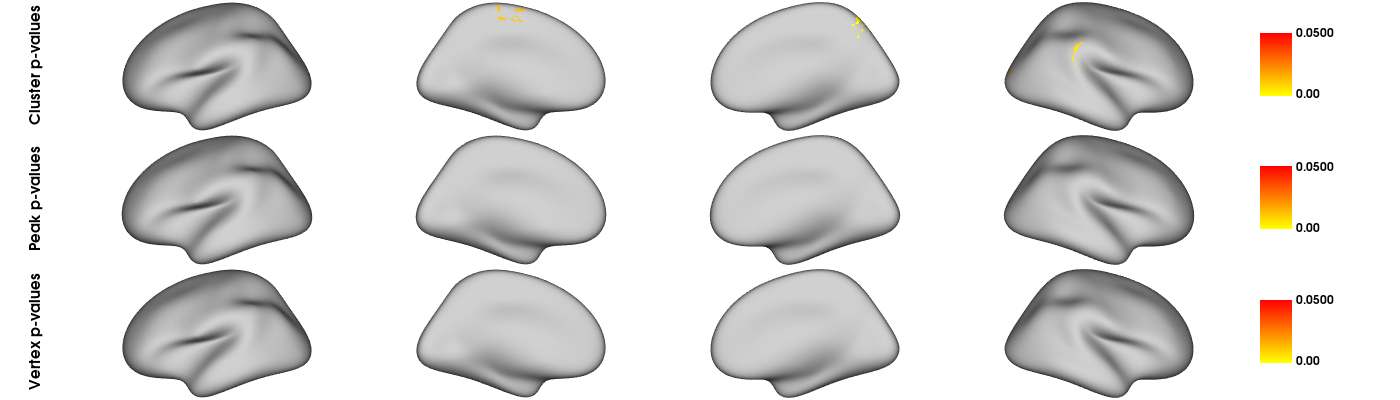

In [152]:
for values,name in zip([reswocov_FIT,reswcov_FIT],["wocov","wcov"]):
    for smoothing_fwhm in smoothing_range:
        figure_title=os.path.join(STUDY_PATH,"screenshots",f"others_stat_sm_{smoothing_fwhm}_{name}.png")
        slm_group=values[f'sm_{smoothing_fwhm}']
        cp = [np.copy(slm_group.P["pval"]["C"])]
        [np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

        pp = [np.copy(slm_group.P["pval"]["P"])]
        [np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

        qp = [np.copy(slm_group.Q)]
        [np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

        vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])
        plot_hemispheres(inflated_left,inflated_right,vals, color_bar=True, color_range=(0, 0.05),
                        label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
                        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
                        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
        display(Image(filename=figure_title))

## Atlas Glasser


 smoothing_fwhm=0

10 [0 0 0 ... 0 0 0] A1_L : p_fdr=0.154 p_value=0.0026

10 [0 0 0 ... 0 0 0] 52_L : p_fdr=0.154 p_value=0.0008

10 [0 0 0 ... 0 0 0] PoI2_L : p_fdr=0.183 p_value=0.0044

10 [0 0 0 ... 0 0 0] MI_L : p_fdr=0.1868 p_value=0.009

10 [0 0 0 ... 0 0 0] H_L : p_fdr=0.154 p_value=0.0015

10 [0 0 0 ... 0 0 0] PoI1_L : p_fdr=0.154 p_value=0.0016

10 [0 0 0 ... 0 0 0] MBelt_L : p_fdr=0.1868 p_value=0.008

10 [0 0 0 ... 0 0 0] A1_R : p_fdr=0.1868 p_value=0.0094

10 [0 0 0 ... 0 0 0] 44_R : p_fdr=0.183 p_value=0.0051

10 [0 0 0 ... 0 0 0] 45_R : p_fdr=0.1868 p_value=0.0094



/tmp/ipykernel_1052597/2808175294.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


10 [0 0 0 ... 0 0 0] PoI2_R : p_fdr=0.154 p_value=0.002

10 [0 0 0 ... 0 0 0] FOP4_R : p_fdr=0.1868 p_value=0.0084

10 [0 0 0 ... 0 0 0] FOP3_R : p_fdr=0.1868 p_value=0.0068

10 [0 0 0 ... 0 0 0] PBelt_R : p_fdr=0.1868 p_value=0.0099

10 [0 0 0 ... 0 0 0] TPOJ1_R : p_fdr=0.183 p_value=0.0049

10 [0 0 0 ... 0 0 0] PoI1_R : p_fdr=0.1868 p_value=0.0083

10 [0 0 0 ... 0 0 0] FOP5_R : p_fdr=0.1868 p_value=0.0066

10 [0 0 0 ... 0 0 0] LBelt_R : p_fdr=0.154 p_value=0.0024

10 [0 0 0 ... 0 0 0] STSva_R : p_fdr=0.183 p_value=0.0044


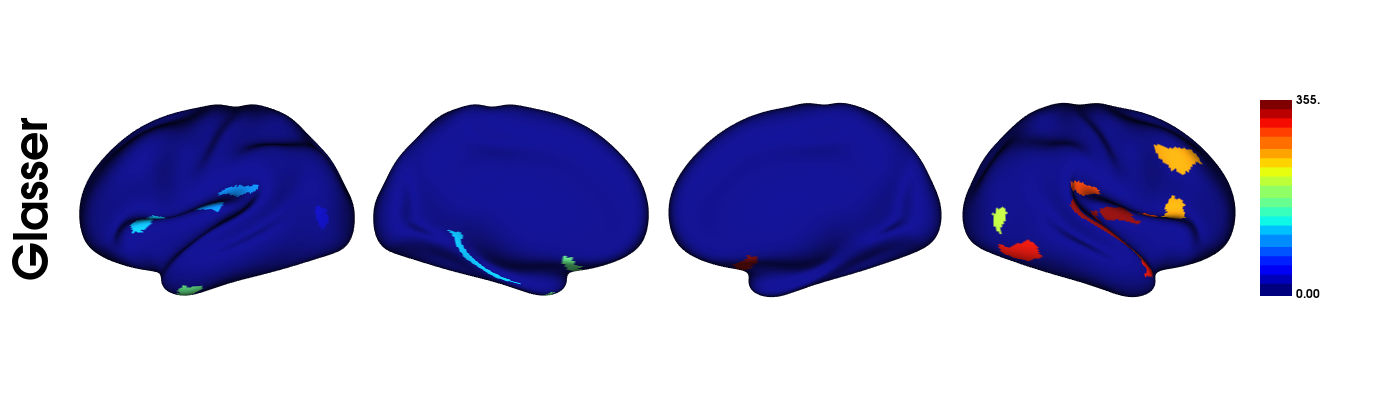

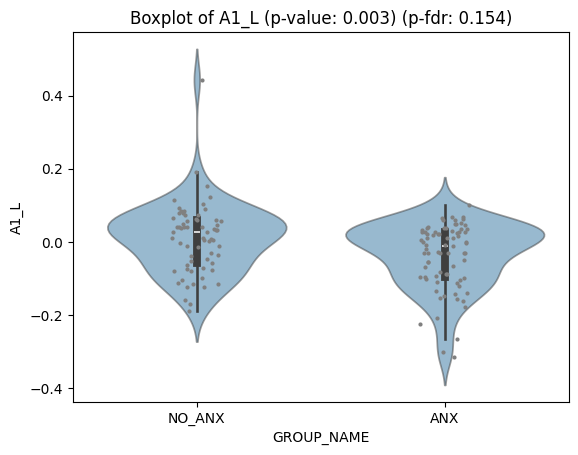

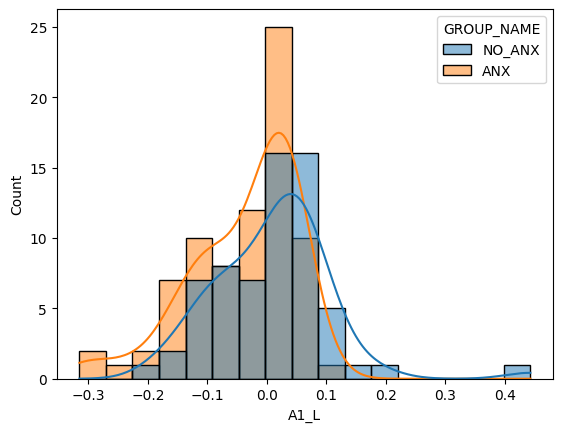

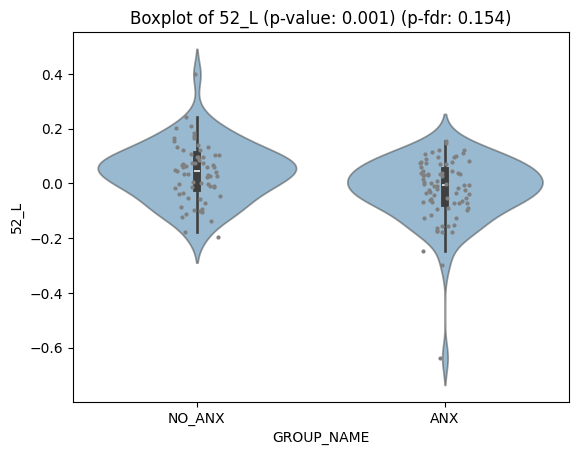

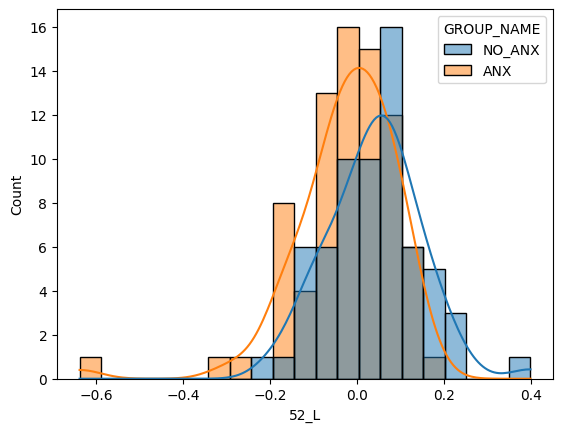

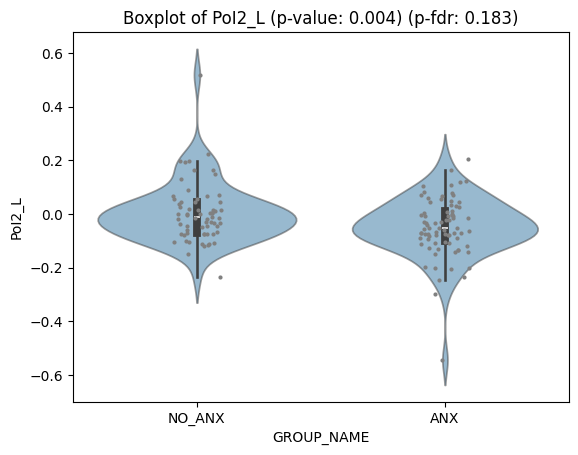

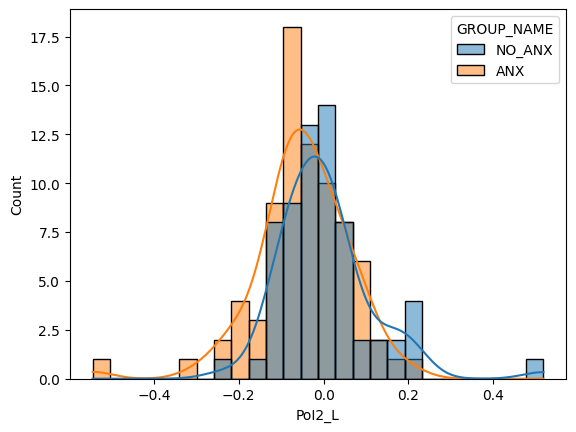

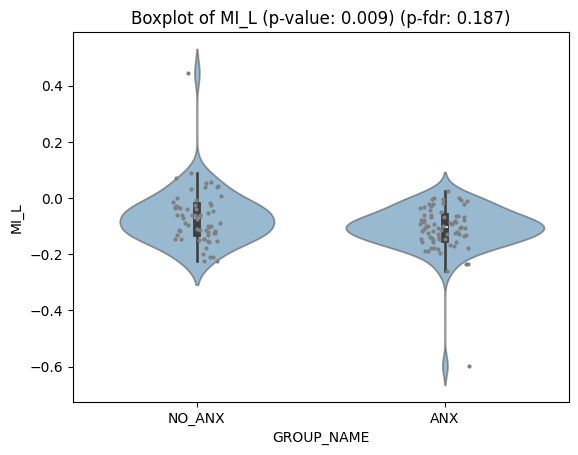

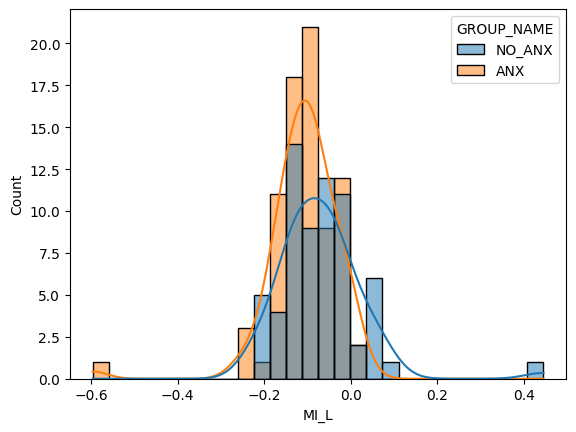

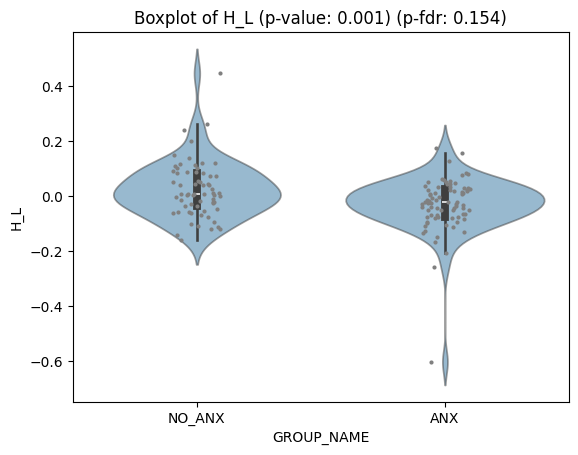

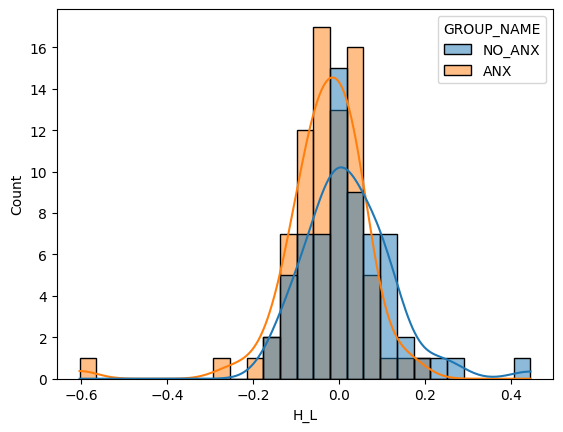

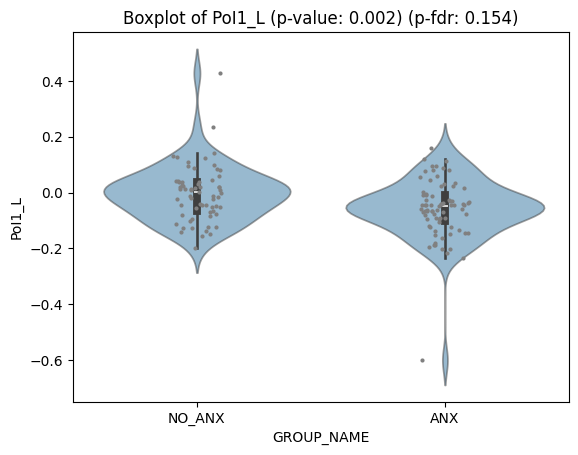

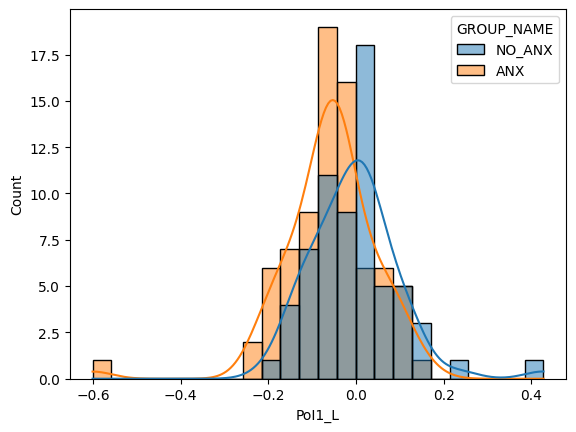

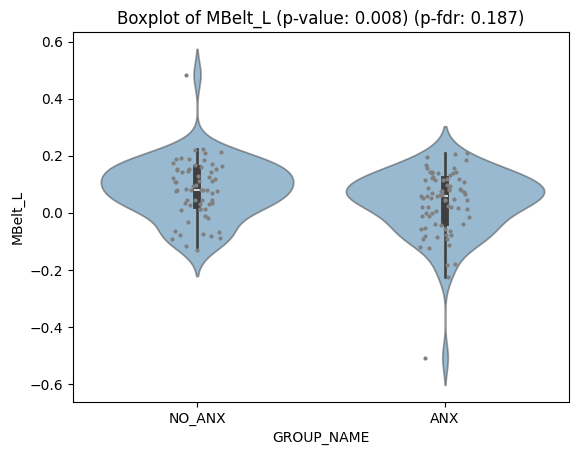

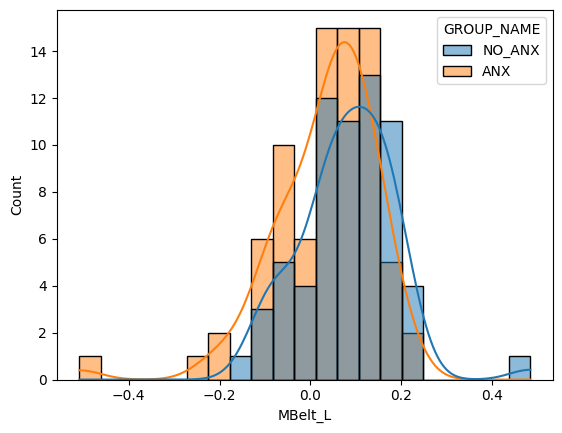

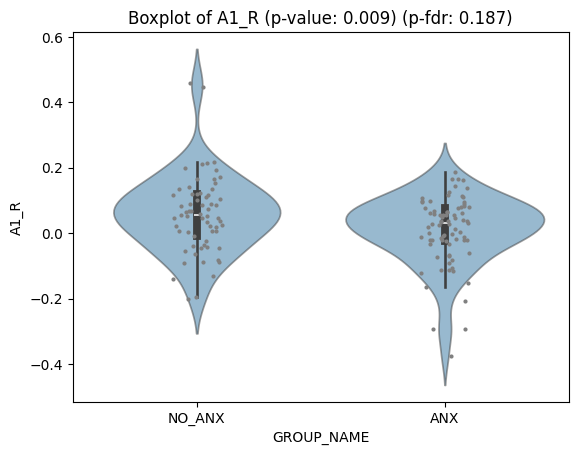

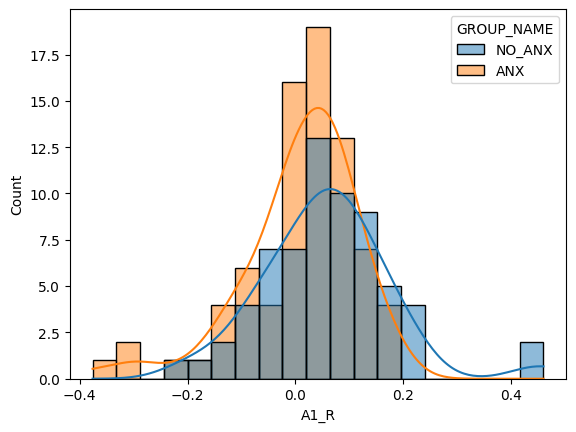

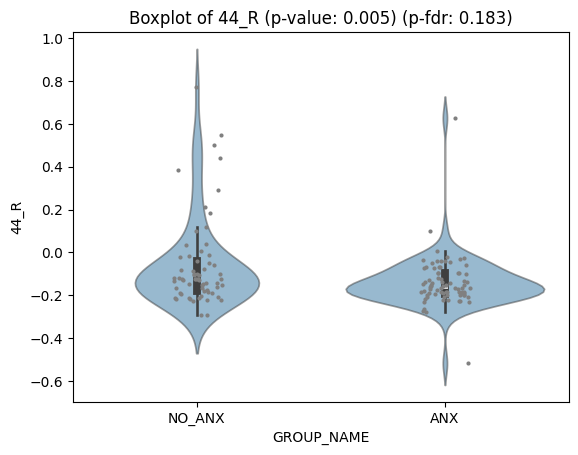

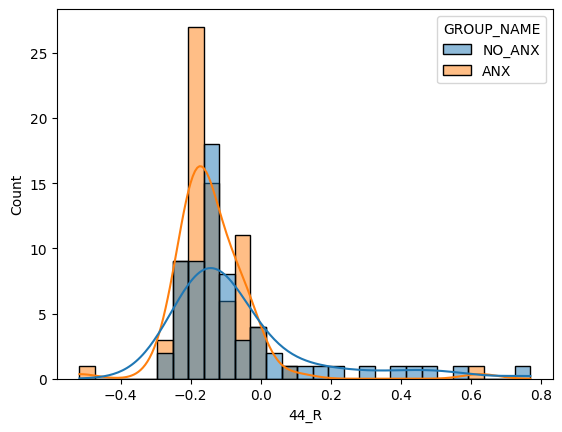

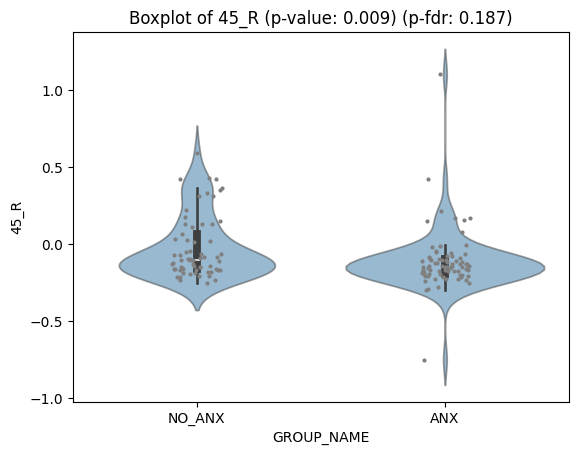

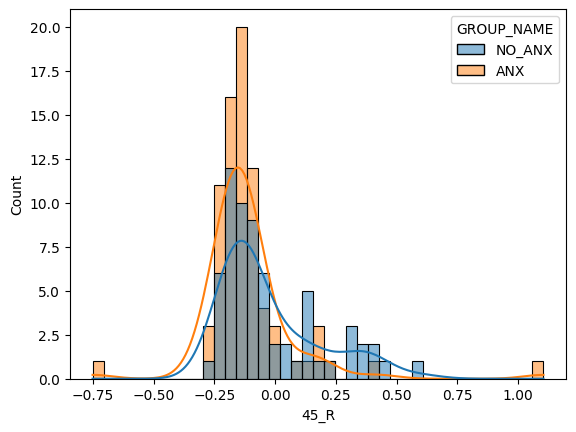

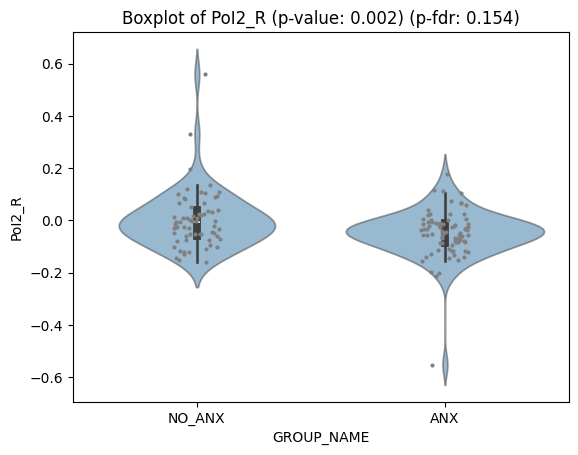

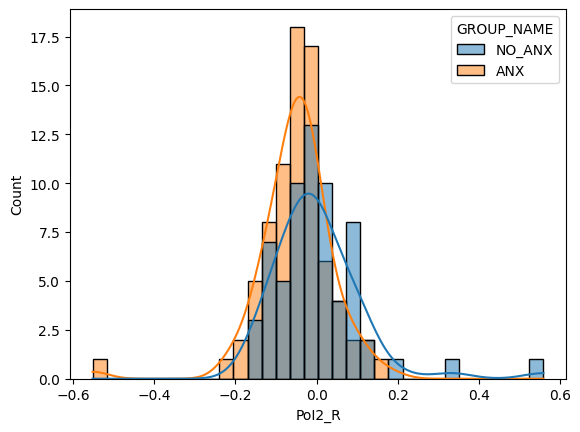

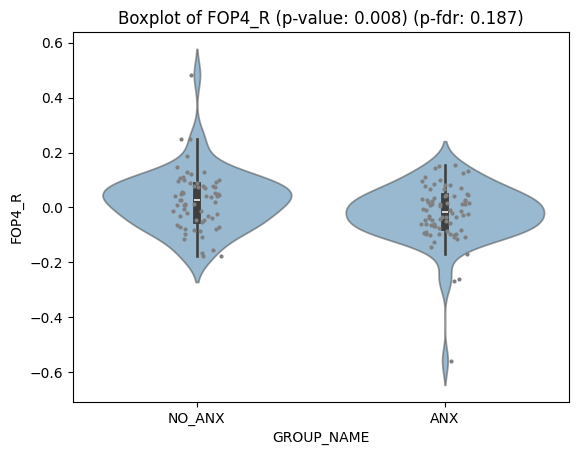

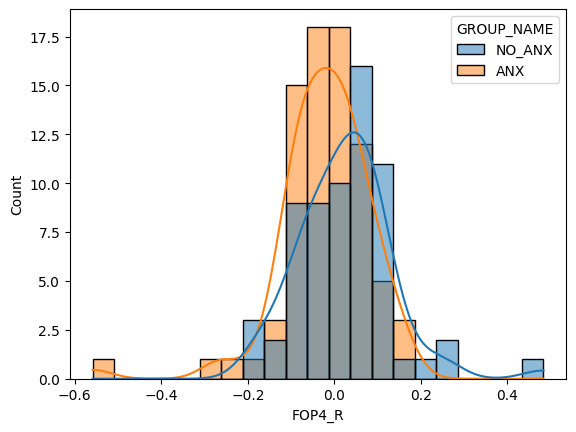

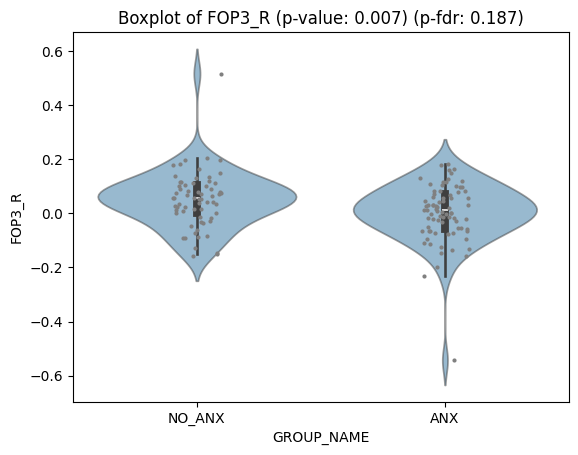

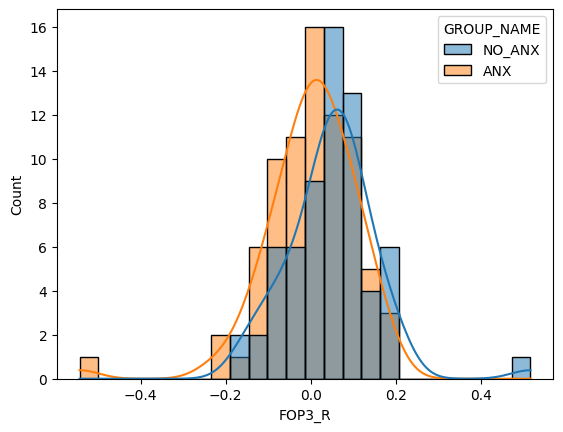

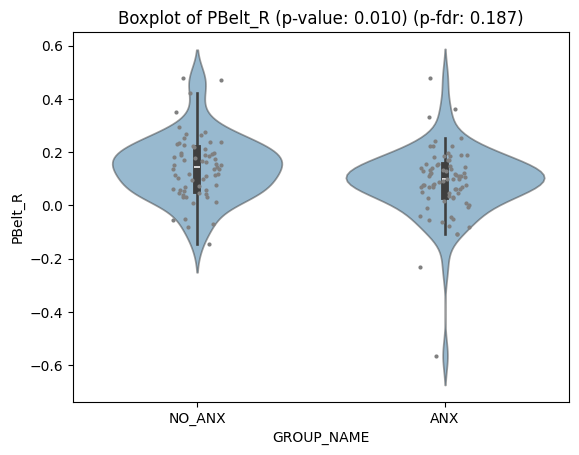

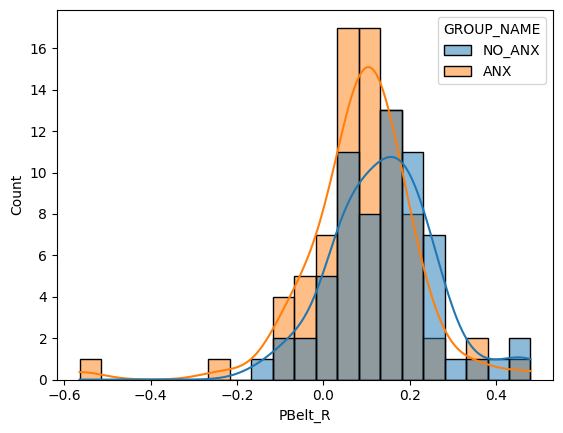

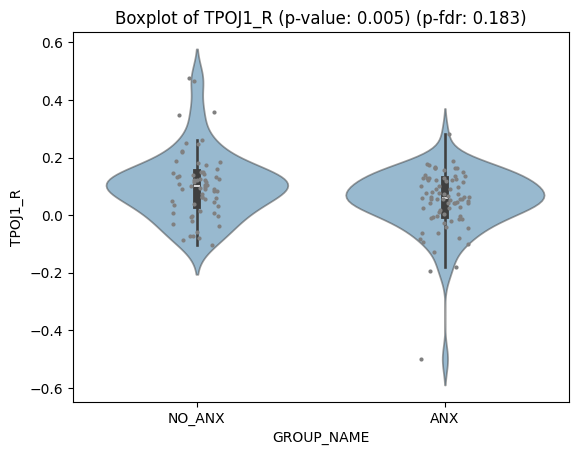

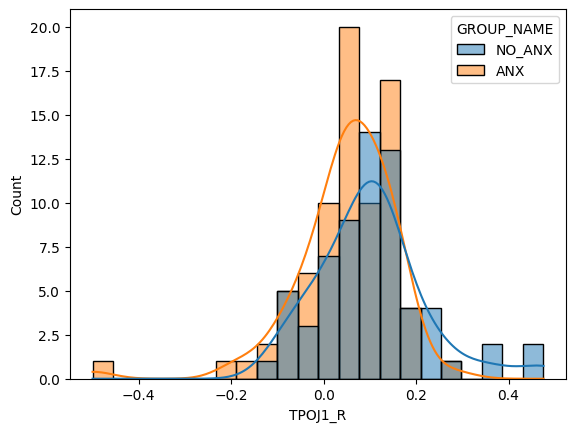

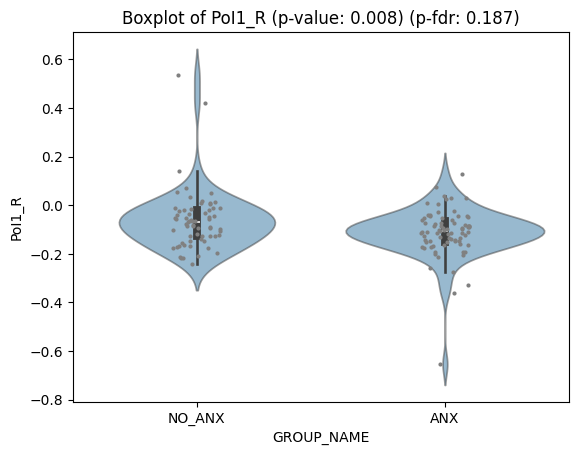

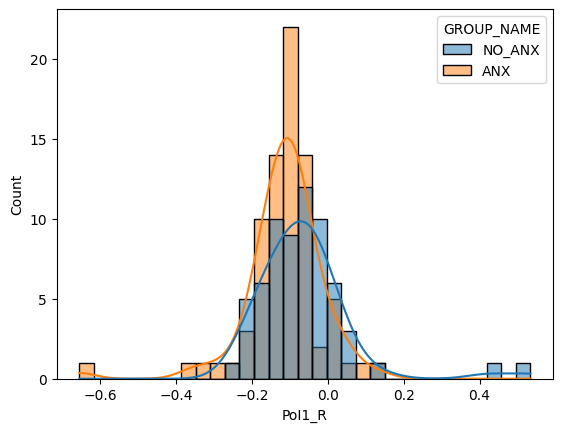

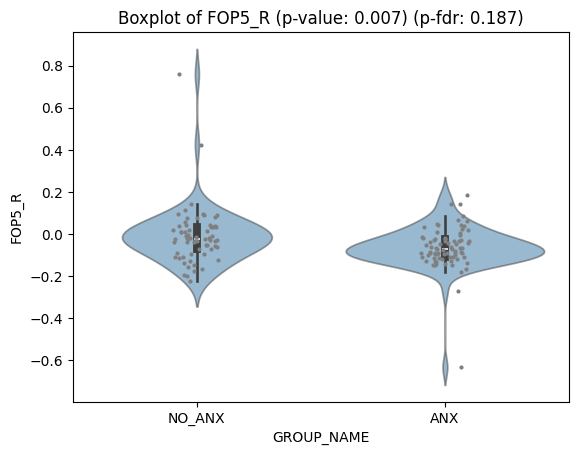

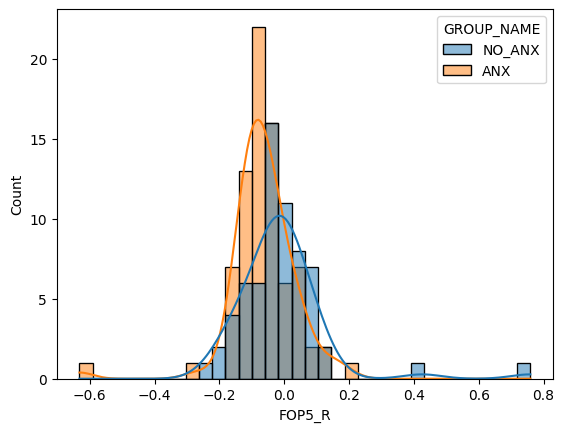

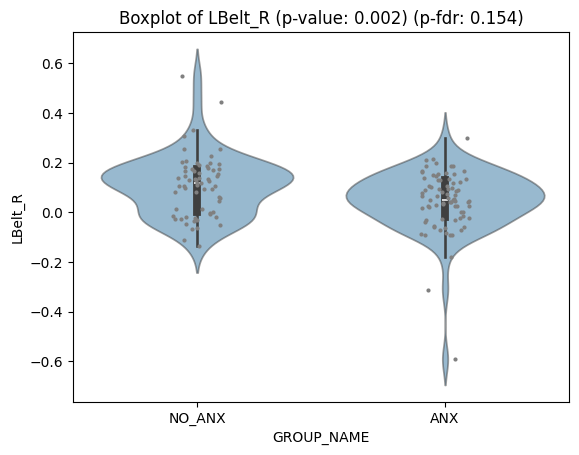

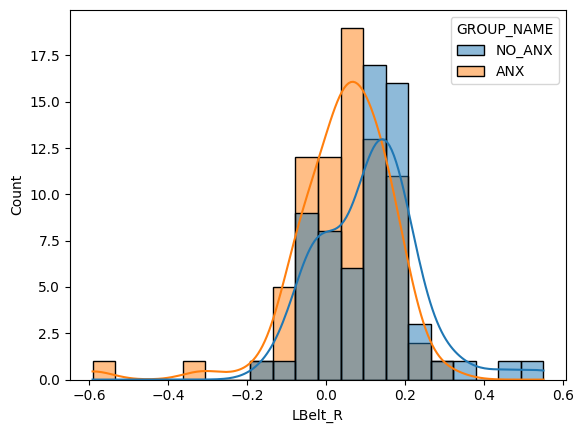

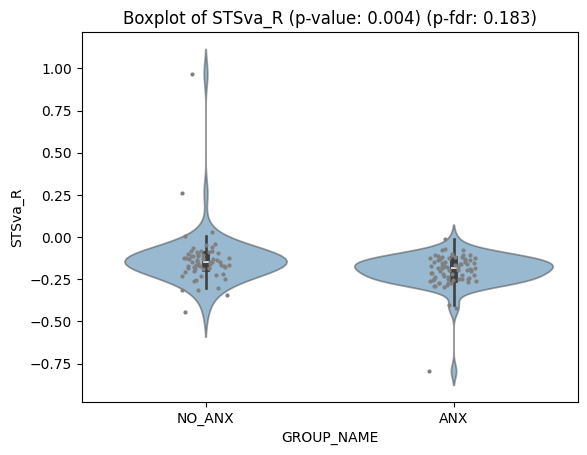

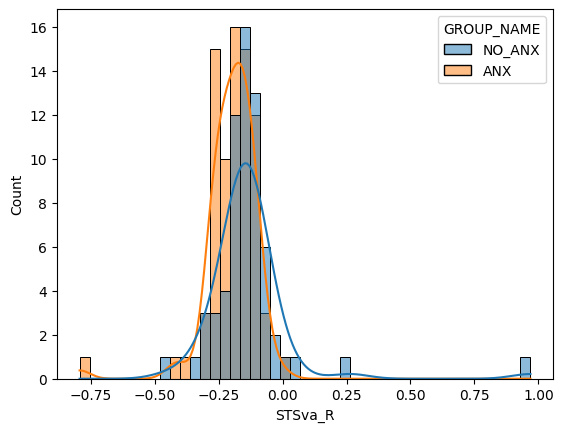

In [153]:
#il manque trois niveau d'education (n=214 à n=211)
covarQuant = ["Age","NB_YEAR_SCHO"]
covarQual=["Sexe","CentreAqui"]

for smoothing_fwhm in smoothing_range:
    print(f"\n smoothing_fwhm={smoothing_fwhm}")

    df_res = pd.DataFrame(np.round(np.array(res[f"sm_{smoothing_fwhm}"]),3), columns=["EXT"]+list(df_exthcp["regionName"].values), index=merged_data.index)
    df_res = df_res.drop(columns=['EXT'])
    df_res = df_res.rename_axis("SUBJ")

    columns_of_interest=list(df_res.columns)
    #columns_of_interest = [col for col in df_res.columns if "FOP4" in col or "AAIC" in col or "PI" in col]
    #columns_of_interest = [col for col in df_res.columns if "23c" in col or "PHT" in col or "TPOJ" in col]  

    p_values=[]
    roiOnGlasser=(glasser_fslr32k==9999999)*0
    merged_data_with_res=merged_data.join(df_res)
    # Remplacer les valeurs infinies par NaN dans le DataFrame merged_data_with_res
    #merged_data_with_res = merged_data_with_res[columns_of_interest+["GROUP_NAME"]].replace([np.inf, -np.inf], np.nan)
    merged_data_with_res=merged_data_with_res[['GROUP_NAME']+covarQuant+covarQual+columns_of_interest].dropna()

    #Régression de l'age et du niveau d'education
    lbr.regress_covar_func(columns_of_interest,covarQuant,merged_data_with_res,merged_data_with_res,False)

    # Fonction pour appliquer le Z-score sur les colonnes d'intérêt
    def apply_zscore(group):
        group[columns_of_interest] = group[columns_of_interest].apply(stats.zscore, axis=1)
        return group

    #Suppression de l'effet centre et sexe en faisant un zscore par combinaison
    # Appliquer le Z-score pour chaque combinaison de Sexe et CentreAqui
    merged_data_with_res_zscore = merged_data_with_res.groupby(['Sexe', 'CentreAqui']).apply(apply_zscore)

    # Effectuer un test t de Student et afficher les boxplots si significatif
    for col in columns_of_interest:
        group1 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'ANX'][col]
        group2 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'NO_ANX'][col]
        #print(f"Effectuer le test t de Student pour la colonne {col}")
        #print(f"Taille du groupe ANX : {group1.shape[0]}")
        #print(f"Taille du groupe NO_ANX : {group2.shape[0]}")
        # Effectuer le test t de Student
        t_stat, p_value = ttest_ind(group1.dropna(), group2.dropna())
        p_values.append(p_value)
        
    b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
    for elt in zip(p_fdr,columns_of_interest,p_values):    
        if elt[2]<0.01 :
            print(f"")
            plt.figure()
            sns.stripplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",size=3,color="gray")
            sns.violinplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",alpha=0.5)
            plt.title(f'Boxplot of {elt[1]} (p-value: {elt[2]:.3f}) (p-fdr: {elt[0]:.3f})')
            p=plt.figure()
            sns.histplot(data=merged_data_with_res_zscore, x=elt[1],kde=True,hue="GROUP_NAME",bins='auto')
            filtered_df = df_exthcp[df_exthcp['regionName'] == elt[1]]
            roi_index=filtered_df['Cortex_ID'].index.values
            roiOnGlasser=roiOnGlasser+((glasser_fslr32k==roi_index)*roi_index)
            #print(f'{lbr.ansi_colors[roiOnGlasser]} {lbr.BOLD} {elt[1]} : p_fdr={round(elt[0],4)} p_value={round(elt[2],4)} {lbr.RESET}')
            print(f{elt[1]} : p_fdr={round(elt[0],4)} p_value={round(elt[2],4)}')

    figure_title=os.path.join(STUDY_PATH,"screenshots",f"Glasser_{smoothing_fwhm}.png")
    plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,roiOnGlasser, color_bar=True,
            label_text=["Glasser"], cmap="jet", 
            embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
            cb__labelTextProperty={"fontSize": 12},transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

## Atlas extended HCP


 smoothing_fwhm=0
Posterior_Cingulate_L  :  0.8926 0.6486
Paracentral_Lobular_and_Mid_Cingulate_L  :  0.8926 0.8076
Anterior_Cingulate_and_Medial_Prefrontal_L  :  0.8926 0.3179
Posterior_Cingulate_R  :  0.8926 0.6716
Paracentral_Lobular_and_Mid_Cingulate_R  :  0.8926 0.6824
Anterior_Cingulate_and_Medial_Prefrontal_R  :  0.8926 0.8926


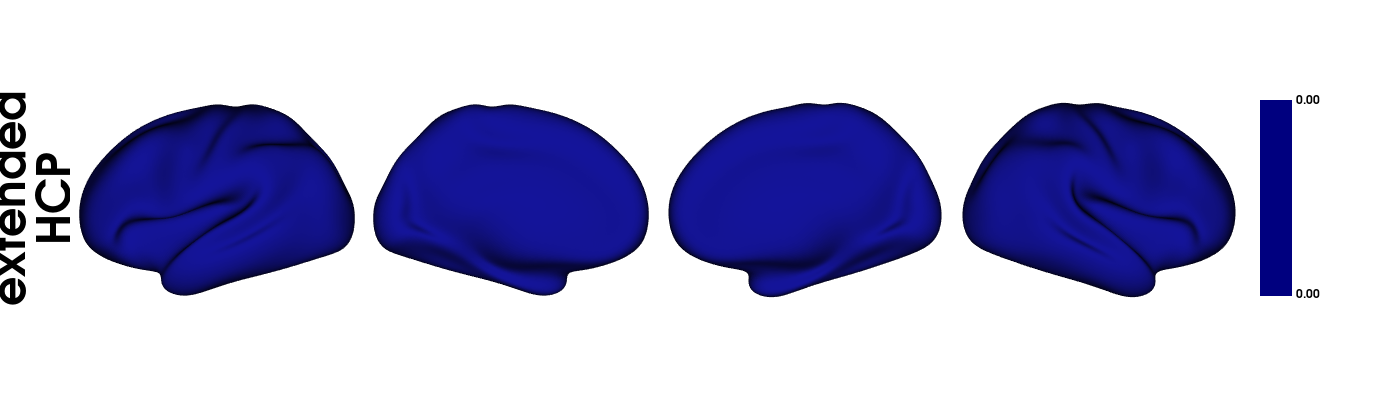

In [155]:
#il manque trois niveau d'education (n=214 à n=211)
covarQuant = ["Age","NB_YEAR_SCHO"]
covarQual=["Sexe","CentreAqui"]

for smoothing_fwhm in range(0, 1, 10):
    print(f"\n smoothing_fwhm={smoothing_fwhm}")
    df_res_exthcp = pd.DataFrame(np.round(np.array(res_exthcp[f"sm_{smoothing_fwhm}"]),3),columns=concatenated_list, index=merged_data.index)
    df_res_exthcp = df_res_exthcp.drop(columns=['EXT'])
    df_res_exthcp = df_res_exthcp.rename_axis("SUBJ")

    columns_of_interest=list(df_res_exthcp.columns)
    columns_of_interest = [col for col in df_res_exthcp.columns if "Cingulate" in col or "AAIC" in col or "PI" in col]

    p_values=[]
    roiOnGlasser=(glasser_fslr32k==9999999)*0
    merged_data_with_res=merged_data.join(df_res_exthcp)
    # Remplacer les valeurs infinies par NaN dans le DataFrame merged_data_with_res
    #merged_data_with_res = merged_data_with_res[columns_of_interest+["GROUP_NAME"]].replace([np.inf, -np.inf], np.nan)
    
    merged_data_with_res=merged_data_with_res[['GROUP_NAME']+covarQuant+covarQual+columns_of_interest].dropna()

    #Régression de l'age et du niveau d'education
    lbr.regress_covar_func(columns_of_interest,covarQuant,merged_data_with_res,merged_data_with_res,False)

    # Fonction pour appliquer le Z-score sur les colonnes d'intérêt
    def apply_zscore(group):
        group[columns_of_interest] = group[columns_of_interest].apply(stats.zscore, axis=1)
        return group

    #Suppression de l'effet centre et sexe en faisant un zscore par combinaison
    # Appliquer le Z-score pour chaque combinaison de Sexe et CentreAqui
    merged_data_with_res_zscore = merged_data_with_res.groupby(['Sexe', 'CentreAqui']).apply(apply_zscore)

    # Effectuer un test t de Student et afficher les boxplots si significatif
    for col in columns_of_interest:
        group1 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'ANX'][col]
        group2 = merged_data_with_res_zscore[merged_data_with_res_zscore['GROUP_NAME'] == 'NO_ANX'][col]
        #print(f"Effectuer le test t de Student pour la colonne {col}")
        #print(f"Taille du groupe ANX : {group1.shape[0]}")
        #print(f"Taille du groupe NO_ANX : {group2.shape[0]}")
        # Effectuer le test t de Student
        t_stat, p_value = ttest_ind(group1.dropna(), group2.dropna())
        p_values.append(p_value)
        
    b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
    for elt in zip(p_fdr,columns_of_interest,p_values):    
        print(elt[1]," : ",round(elt[0],4),round(elt[2],4))
        if elt[2]<0.06 :
            print(elt)
            print(elt[1]," : ",round(elt[0],4))
            plt.figure()
            sns.stripplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",size=3,color="gray")
            sns.violinplot(data=merged_data_with_res_zscore,y=elt[1],x="GROUP_NAME",alpha=0.5)
            plt.title(f'Boxplot of {elt[1]} (p-value: {elt[2]:.3f}) (p-fdr: {elt[0]:.3f})')
            p=plt.figure()
            sns.histplot(data=merged_data_with_res_zscore, x=elt[1],kde=True,hue="GROUP_NAME",bins='auto')
            filtered_df = df_exthcp[df_exthcp['cortex'] == elt[1][:-2]]
            if elt[1][-1]=="L":
                roi_index=filtered_df['Cortex_ID'].unique()
            else :
                roi_index=filtered_df['Cortex_ID'].unique()+22 
            roiOnGlasser=roiOnGlasser+((glasser_fslr32k_exthcp==roi_index)*roi_index)

    figure_title=os.path.join(STUDY_PATH,"screenshots",f"HCP_ext_{smoothing_fwhm}.png")

    plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,roiOnGlasser, color_bar=True,
            label_text=["extended\nHCP"], cmap="jet", 
            embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
            cb__labelTextProperty={"fontSize": 12},transparent_bg=False,screenshot=True, offscreen=False,filename=figure_title)
    display(Image(filename=figure_title))

# affichage des regions selectionnées

L_V1 1
L_MST 2
L_V6 3
L_V2 4
L_V3 5
L_V4 6
L_V8 7
L_4 8
L_3b 9
L_FEF 10
L_PEF 11
L_55b 12
L_V3A 13
L_RSC 14
L_POS2 15
L_V7 16
L_IPS1 17
L_FFC 18
L_V3B 19
L_LO1 20
L_LO2 21
L_PIT 22
L_MT 23
L_A1 24
L_PSL 25
L_SFL 26
L_PCV 27
L_STV 28
L_7Pm 29
L_7m 30
L_POS1 31
L_23d 32
L_v23ab 33
L_d23ab 34
L_31pv 35
L_5m 36
L_5mv 37
L_23c 38
L_5L 39
L_24dd 40
L_24dv 41
L_7AL 42
L_SCEF 43
L_6ma 44
L_7Am 45
L_7PL 46
L_7PC 47
L_LIPv 48
L_VIP 49
L_MIP 50
L_1 51
L_2 52
L_3a 53
L_6d 54
L_6mp 55
L_6v 56
L_p24pr 57
L_33pr 58
L_a24pr 59
L_p32pr 60
L_a24 61
L_d32 62
L_8BM 63
L_p32 64
L_10r 65
L_47m 66
L_8Av 67
L_8Ad 68
L_9m 69
L_8BL 70
L_9p 71
L_10d 72
L_8C 73
L_44 74
L_45 75
L_47l 76
L_a47r 77
L_6r 78
L_IFJa 79
L_IFJp 80
L_IFSp 81
L_IFSa 82
L_p9-46v 83
L_46 84
L_a9-46v 85
L_9-46d 86
L_9a 87
L_10v 88
L_a10p 89
L_10pp 90
L_11l 91
L_13l 92
L_OFC 93
L_47s 94
L_LIPd 95
L_6a 96
L_i6-8 97
L_s6-8 98
L_43 99
L_OP4 100
L_OP1 101
L_OP2-3 102
L_52 103
L_RI 104
L_PFcm 105
L_PoI2 106
L_TA2 107
L_FOP4 108
L_MI 109
L_Pir 110
L

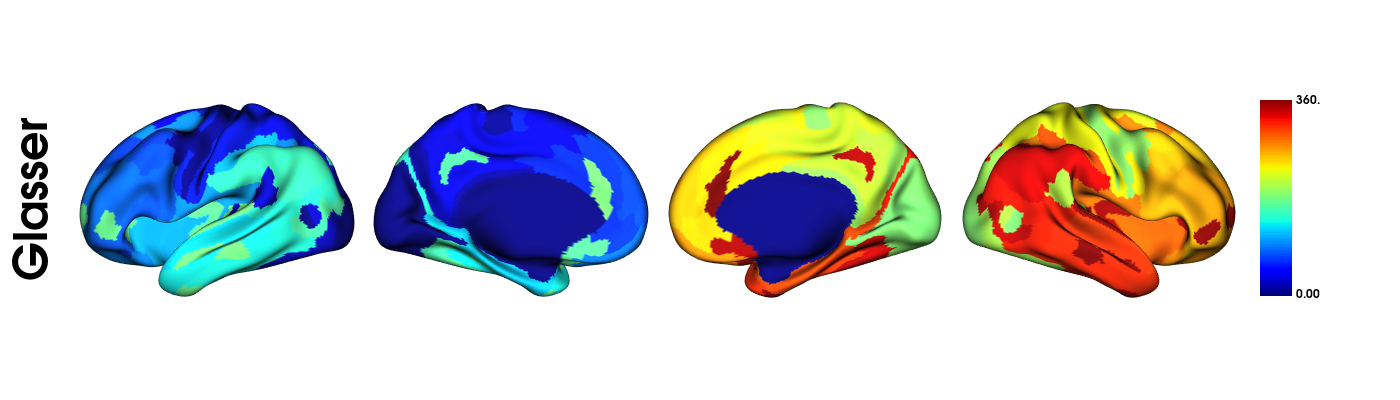

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
p_values=[]
roiOnGlasser=(glasser_fslr32k==9999999)*0
merged_data_with_res=merged_data.join(df_res) 
columns_of_interest=df_res.columns
#columns_of_interest = [col for col in df_res.columns if "FOP4" in col or "AAIC" in col or "PI" in col]  

# Effectuer un test t de Student et afficher les boxplots si significatif
for col in columns_of_interest:
    indice_R_TE2p = glasser360_aires_list.index(col)
    print(col,indice_R_TE2p)    
    roiOnGlasser=roiOnGlasser+((glasser_fslr32k==indice_R_TE2p)*indice_R_TE2p)
        
plot_hemispheres(inflated_left_fslr32k,inflated_right_fslr32k,roiOnGlasser, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)